In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy as sp
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm

warnings.filterwarnings('ignore')
%matplotlib inline

np.random.seed(123)

# Bayesian Learning for coin

1 - head<br>
0 - tail

For 10 tosses: head prob: 0.300000, tail prob: 0.700000
For 50 tosses: head prob: 0.480000, tail prob: 0.520000
For 100 tosses: head prob: 0.540000, tail prob: 0.460000
For 1000 tosses: head prob: 0.532000, tail prob: 0.468000
For 5000 tosses: head prob: 0.490000, tail prob: 0.510000
For 10000 tosses: head prob: 0.495700, tail prob: 0.504300


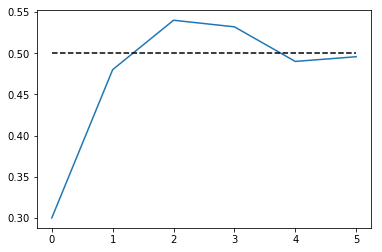

In [2]:
'''
Чем больше эксперементов тем более честной становится монетка
вероятность орла = вероятности решки = 0.5
'''

def coin_test_freq():
    tosses = [10, 50, 100, 1000, 5000, 10000]
    probs = []
    for toss in tosses:
        data = np.random.randint(0, 2, toss)
        head_prob = data.sum()/data.shape[0]
        probs.append(head_prob)
        print("For %d tosses: head prob: %f, tail prob: %f"
              %(toss, head_prob, 1 - head_prob))
    plt.plot(probs)
    plt.plot(range(len(tosses)), np.repeat(0.5, len(tosses)),
             color='black', linewidth=1.5, linestyle='dashed')
    plt.show()
    
coin_test_freq()

Beta distribution: (used as prior)


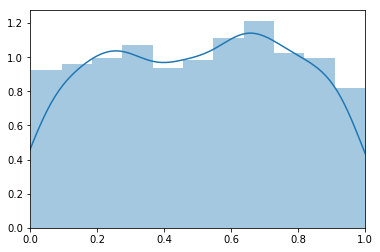

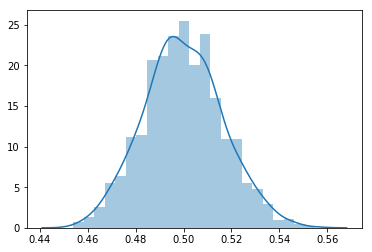

Обучение модели
alpha: 1.000000, beta: 1.000000


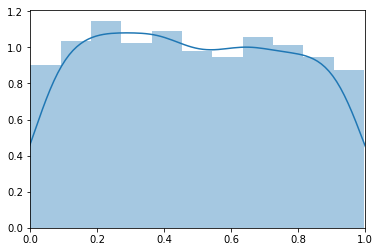

alpha: 619.000000, beta: 658.000000


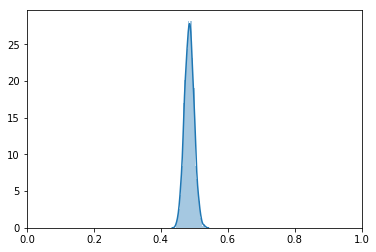

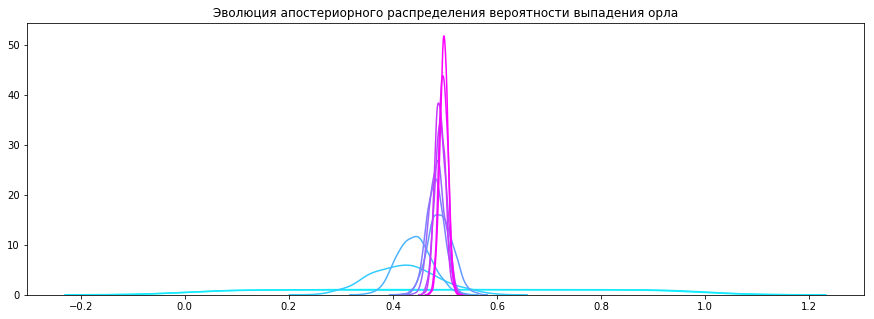

In [4]:
def coin_test_bayesian():
    print("Beta distribution: (used as prior)")
    beta = np.random.beta(1, 1, 1000)
    plt.xlim([0, 1])
    sns.distplot(beta)
    plt.show()
    data = np.random.binomial(1000, .5, 1000) / 1000
    sns.distplot(data)
    plt.show()
    
    print("Обучение модели")
    N = list(range(100))
    alpha = 1
    beta = 1
    beta_params = [(alpha, beta)]
    
    for n in N:
        k = np.random.binomial(n, 0.5)
        alpha = k + alpha
        beta = n + beta - k
        if n % 10 == 0:
            beta_params.append((alpha, beta))
        if n % 50 == 0:
            print("alpha: %f, beta: %f" %(alpha, beta))
            posterior = np.random.beta(alpha, beta, 1000)
            sns.distplot(posterior)
            plt.xlim([0, 1])
            plt.show()
            
    fig, ax = plt.subplots(figsize=(15, 5))
    cmap = plt.get_cmap('cool')
#     plot_pdf(posterior(0, 0), ax, cmap(0))
    for (alpha, beta), c in zip(beta_params, np.linspace(0, 1, num=len(beta_params))):
        posterior = np.random.beta(alpha, beta, 1000)
        sns.distplot(posterior, hist=False, color=cmap(c), norm_hist=True)

    plt.title('Эволюция апостериорного распределения вероятности выпадения орла')
    plt.show()
        

coin_test_bayesian()

# MCMC sampling

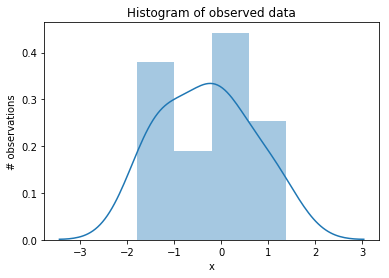

In [9]:
data = np.random.randn(20)
ax = plt.subplot()
sns.distplot(data, kde=True, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

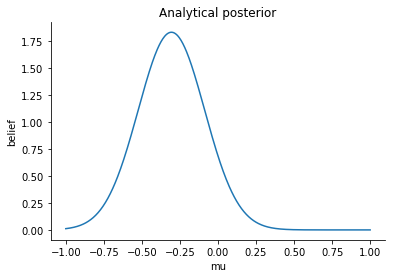

In [10]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

In [31]:
mu_current = 1.
proposal_width = 1.
proposal = norm(mu_current, proposal_width).rvs()
print(proposal)

likelihood_current = norm(mu_current, 1).pdf(data).prod()
print("likelihood_current: ", likelihood_current)
mu_proposal = proposal
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
print("likelihood_proposal: ", likelihood_proposal)

# начаньное, априорное значение mu
mu_prior_mu = 0
mu_prior_sd = 1

# Compute prior probability of current and proposed mu        
prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
print("prior_current: ", prior_current)
prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
print("prior_proposal: ", prior_proposal)

# computing of posterior
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal

p_accept = p_proposal / p_current
p_accept

1.3170095741921628
likelihood_current:  5.377240349258482e-20
likelihood_proposal:  4.531656632298581e-24
prior_current:  0.24197072451914337
prior_proposal:  0.16759655559939682


5.837135982171364e-05

In [41]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in tqdm(range(samples)):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density',
            title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' 
            % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=True, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f'
            % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f'
            % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

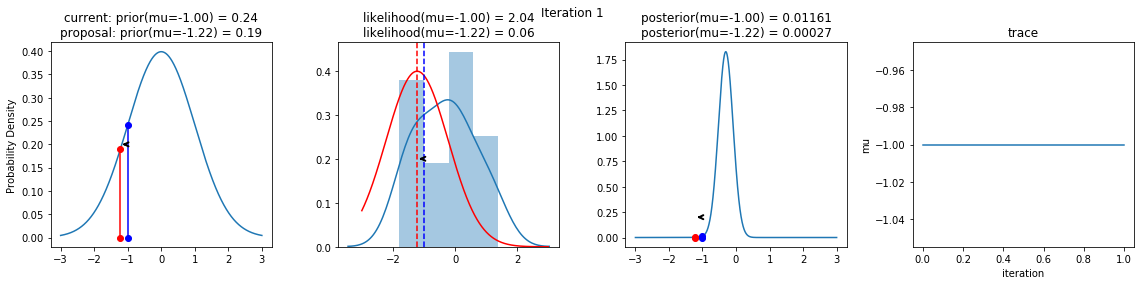

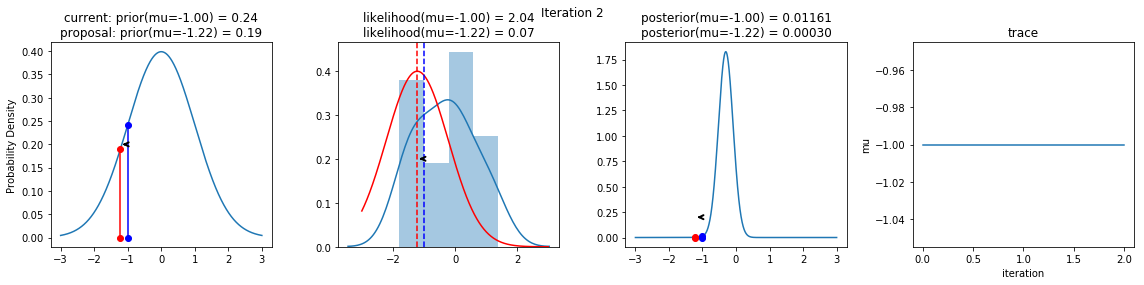

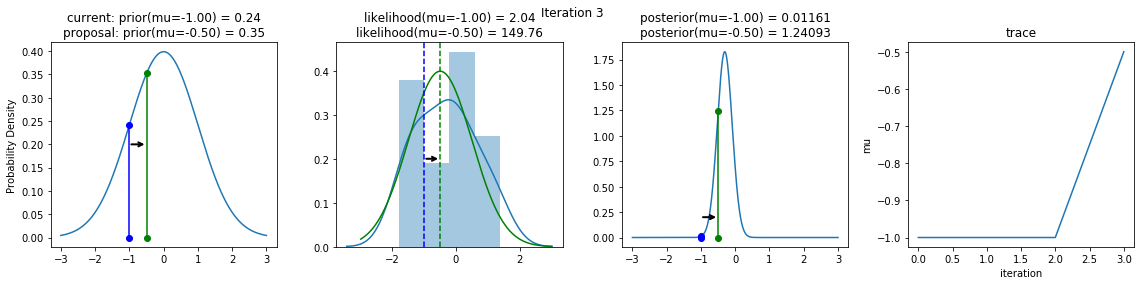

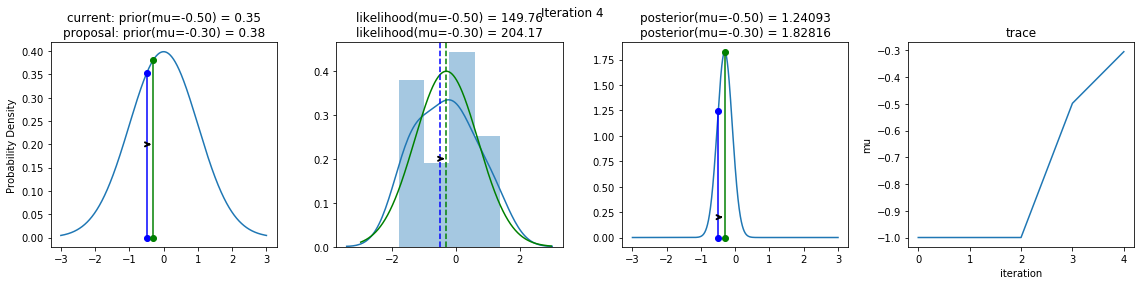

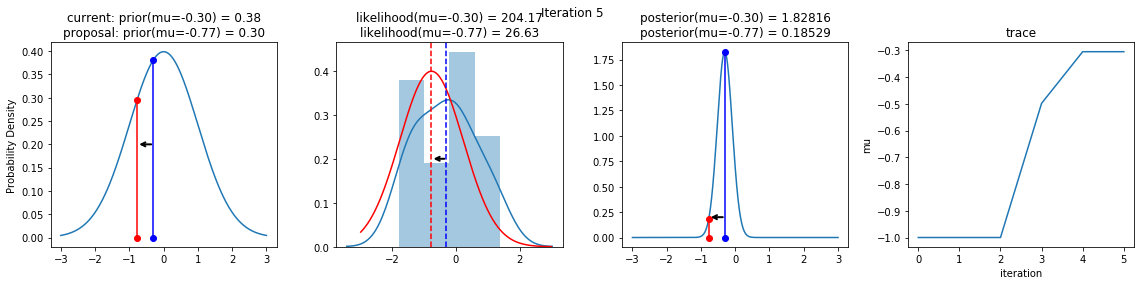

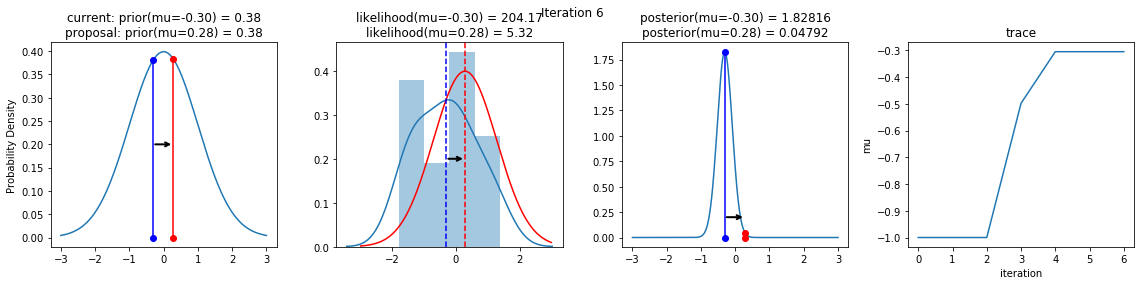

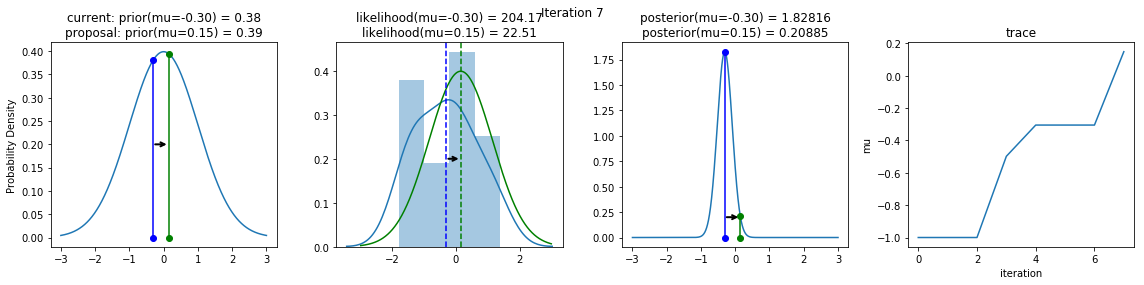

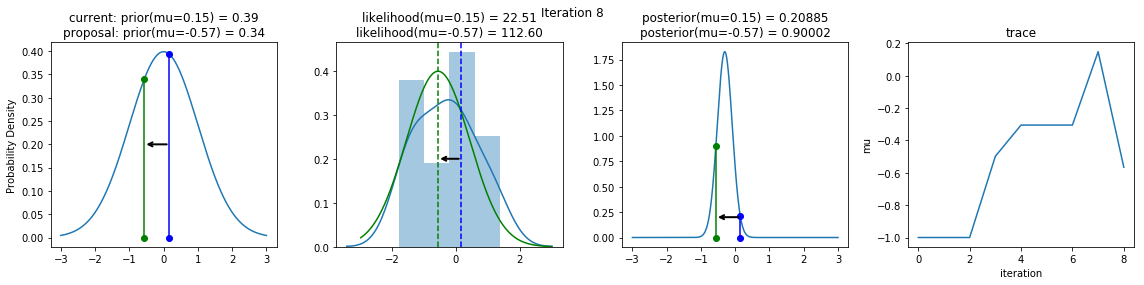

In [38]:
# np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);

HBox(children=(IntProgress(value=0, max=15000), HTML(value='')))

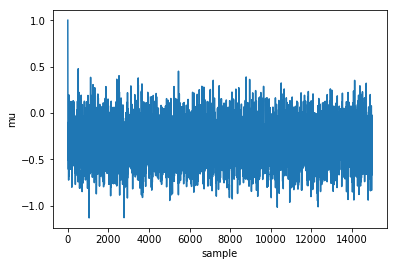

In [42]:
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

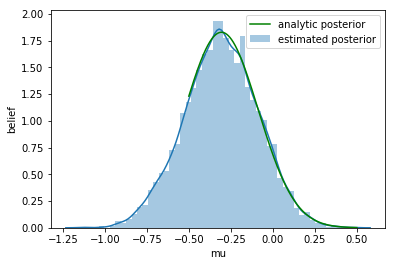

In [43]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

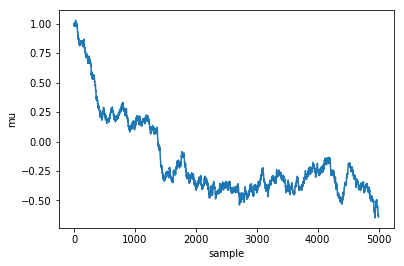

In [44]:
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

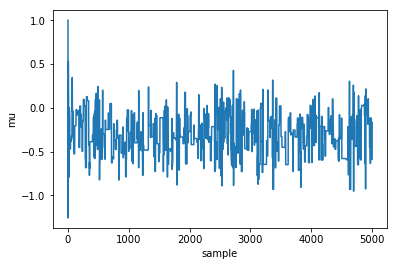

In [45]:
posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');

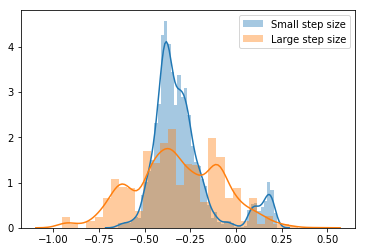

In [46]:
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior_large[1000:], label='Large step size');
_ = plt.legend();